In [11]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
import configs

# Arguments

In [12]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
pickles_dir = f'{engram_dir}pickles/'
bg_types = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snr_types = [-9.0, -6.0, -3.0, 0.0, 3.0]

# Plotting

In [14]:
os.listdir(pickles_dir)

['.DS_Store',
 'pnet_cgram_shuffle_denoising',
 'old_factorization',
 'pnet_shuffle_invariance_fold1.p',
 'random_matched_denoising',
 'sound_stationarity',
 'pnet_invariance_fold1.p',
 'pnet_denoising',
 'pnet_shuffle_factorization_fold0.p',
 'pnet_dimensionality.p',
 'pnet_shuffle_invariance_fold0.p',
 'pnet_factorization.p',
 'dead_units.p',
 'pnet_merged_denoising']

In [18]:
with open(f'{pickles_dir}{netname}_factorization.p', 'rb') as f:
    df = pickle.load(f)

Text(0.5, 1.0, 'All')

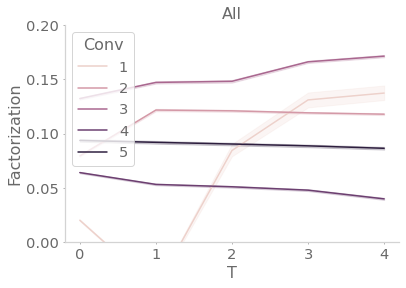

In [20]:
fig, ax = plt.subplots()
_df = df.copy()
_df['Factorization'] = 1 - _df['Factorization']
sns.lineplot(
    x='T', y='Factorization', hue='Conv',
    hue_order=[1,2,3,4,5],
    data=_df, ax=ax)
ax.set_ylim(0,0.2)
ax.set_title(f'All')

In [22]:
with open(f'{pickles_dir}{netname}_shuffle_factorization_fold0.p', 'rb') as f:
    df = pickle.load(f)

Text(0.5, 1.0, 'All')

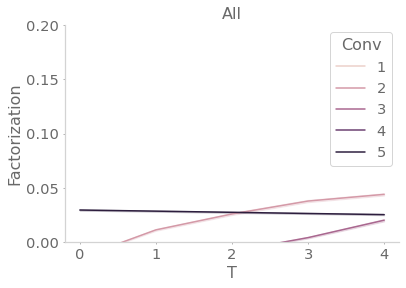

In [25]:
fig, ax = plt.subplots()
_df = df.copy()
_df['Factorization'] = 1 - _df['Factorization']
sns.lineplot(
    x='T', y='Factorization', hue='Conv',
    hue_order=[1,2,3,4,5],
    data=_df, ax=ax)
ax.set_ylim(0,0.2)
ax.set_title(f'All')

In [17]:
with open(f'{pickles_dir}old_factorization/{netname}_factorization.p', 'rb') as f:
    df = pickle.load(f)

Text(0.5, 1.0, 'All')

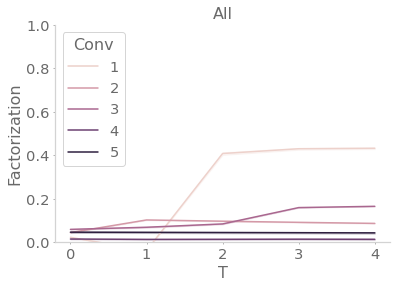

In [8]:
fig, ax = plt.subplots()
_df = df.copy()
_df['Factorization'] = 1 - _df['Factorization']
sns.lineplot(
    x='T', y='Factorization', hue='Conv',
    hue_order=[1,2,3,4,5],
    data=_df, ax=ax)
ax.set_ylim(0,1)
ax.set_title(f'All')

In [ ]:
with open(f'{pickles_dir}{netname}_shuffle_factorization.p', 'rb') as f:
    df = pickle.load(f)

In [ ]:
fig, ax = plt.subplots()
_df = df.copy()
_df['Factorization'] = 1 - _df['Factorization']
sns.lineplot(
    x='T', y='Factorization', hue='Conv',
    hue_order=[2,3,4],
    data=_df, ax=ax)
ax.set_ylim(0, 1)
ax.set_title(f'All')